In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model

Base = automap_base()

# reflect the tables

Base.prepare(engine, reflect = True)

In [9]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table

Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB

session = Session(engine)

In [ ]:
# Checking that Python is connected to DB and fetching data

#sttn = session.query(Station).all()
#for i in sttn:
    #print(f"{i.name}")

In [9]:
# Get table names

inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [10]:
# Fetch data to see all columns and data types from 'measurement table'
columns = inspector.get_columns('measurement')

for col in columns:
    print(col["name"], "-->",col["type"])

id --> INTEGER
station --> TEXT
date --> TEXT
prcp --> FLOAT
tobs --> FLOAT


In [11]:
# Fetch data to see all columns and data types from 'sttion table'
columns = inspector.get_columns('station')

for col in columns:
    print(col["name"], "-->",col["type"])

id --> INTEGER
station --> TEXT
name --> TEXT
latitude --> FLOAT
longitude --> FLOAT
elevation --> FLOAT


In [12]:
# Fetch first 5 rows from measurement table

query = text("SELECT * FROM measurement LIMIT 5")
result = engine.connect().execute(query)
rows = result.fetchall()

for r in rows:
    print(r)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


In [13]:
# Fetch first all rows from station table

query = text("SELECT * FROM station;")
result = engine.connect().execute(query)
rows = result.fetchall()

for r in rows:
    print(r)

(1, 'USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)
(2, 'USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6)
(3, 'USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0)
(4, 'USC00517948', 'PEARL CITY, HI US', 21.3934, -157.9751, 11.9)
(5, 'USC00518838', 'UPPER WAHIAWA 874.3, HI US', 21.4992, -158.0111, 306.6)
(6, 'USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5)
(7, 'USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9)
(8, 'USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 21.3152, -157.9992, 0.9)
(9, 'USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4)


# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date

('2017-08-23',)

In [25]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

query = text("SELECT MAX(date) FROM Measurement")
most_recent_date = engine.connect().execute(query)
print("Most recent date: ",most_recent_date.scalar())

# Calculate the date one year from the last date in data set.

year_ago_date = dt.date(2017,8,23) - dt.timedelta(days = 365)
print("Yeat ago date: ",year_ago_date)

# Perform a query to retrieve the data and precipitation scores

precipitation_year_ago = session.query(Measurement.date, Measurement.prcp).\
                                    filter(Measurement.date>=year_ago_date).all()
precipitation_year_ago

# Save the query results as a Pandas DataFrame. Explicitly set the column names

df_measurement_prcp = pd.DataFrame(precipitation_year_ago,columns = ["date","precipitation"])
df_measurement_prcp

# Sort the dataframe by date
df_measurement_prcp.sort_values(by = "date", inplace = True)
df_measurement_prcp.set_index("date", inplace = True)
df_measurement_prcp.head()



Most recent date:  2017-08-23
Yeat ago date:  2016-08-23


,precipitation
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


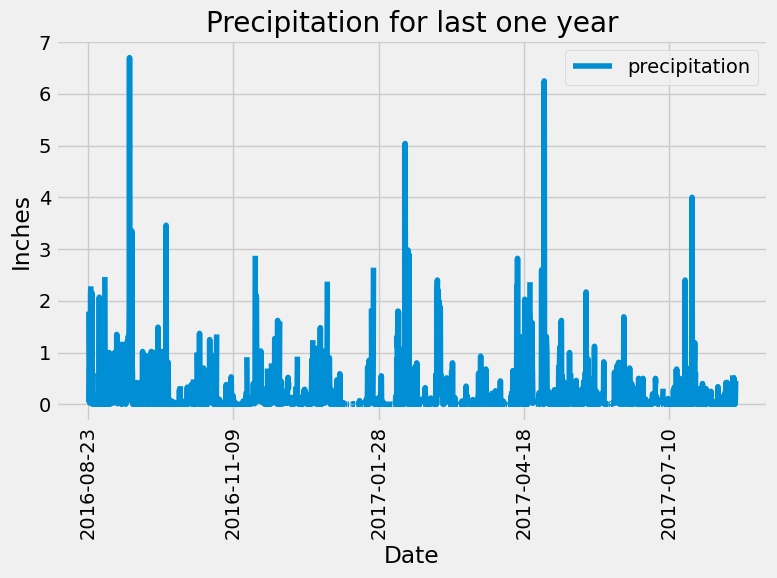

<Figure size 640x480 with 0 Axes>

In [27]:
# Use Pandas Plotting with Matplotlib to plot the data
df_measurement_prcp.plot(figsize=(8,6))

plt.xticks(rotation = 90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.title("Precipitation for last one year")
plt.tight_layout()
plt.show()


In [28]:
# Use Pandas to calculate the summary statistics for the precipitation data

summary_statistics = df_measurement_prcp.describe()
print(summary_statistics)

       precipitation
count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [30]:
# Design a query to calculate the total number of stations in the dataset

query = "SELECT COUNT(DISTINCT station) AS total_station FROM measurement;"
result = engine.connect().execute(text(query))
result.all()

[(9,)]

In [31]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

query = "SELECT station, COUNT(*) AS row_count\
         FROM measurement\
         GROUP BY station\
         ORDER BY row_count DESC"
result = engine.connect().execute(text(query))
active_station = result.fetchall()
active_station


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [32]:
most_active_station = active_station[0][0]
print(f"Most active station is: {most_active_station}")

Most active station is: USC00519281


In [33]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average 
#                                                                                          temperature.

temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                    filter(Measurement.station == active_station[0][0]).order_by(func.min(Measurement.tobs)).all()
#temp = session.query(func.min(Measurement.tobs),func.max(Measurement.tobs),func.avg(Measurement.tobs)).\
                    #filter(Measurement.station == 'USC00519281').order_by(func.min(Measurement.tobs)).all()
temp_data = {"min_temperature": temp[0][0],
             "max_temperature": temp[0][1],
             "avg_temperature": temp[0][2]
             }
temp_data

{'min_temperature': 54.0,
 'max_temperature': 85.0,
 'avg_temperature': 71.66378066378067}

In [34]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot 
                                  #the results as a histogram


year_temp = session.query(Measurement.tobs).filter(Measurement.date >= year_ago_date,\
                                                   Measurement.station == "USC00519281").\
                                                   order_by(Measurement.date)
year_temp.all()

year_temp_df = pd.DataFrame(year_temp,columns=["Tobs"])
year_temp_df


,Tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0
...,...
347,77.0
348,77.0
349,76.0
350,76.0


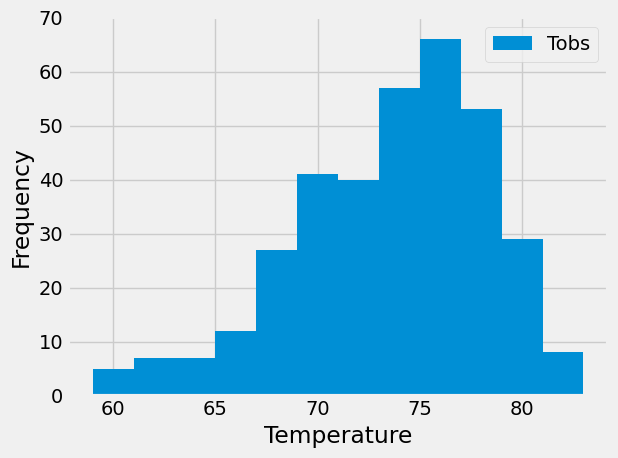

In [36]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and 
  # plot the results as a histogram

year_temp_df.plot.hist(bins = 12)
plt.ylim(0,70)

plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


# Close Session

In [12]:
# Close Session
session.close()